# TSSL Lab 3 - Nonlinear state space models and Sequential Monte Carlo
In this lab we will make use of a non-linear state space model for analyzing the dynamics of SARS-CoV-2, the virus causing covid-19. We will use an epidemiological model referred to as a Susceptible-Exposed-Infectious-Recovered (SEIR) model. It is a stochastic adaptation of the model used by the The Public Health Agency of Sweden for predicting the spread of covid-19 in the Stockholm region early in the pandemic, see [Estimates of the peak-day and the number of infected individuals during the covid-19 outbreak in the Stockholm region, Sweden February – April 2020](https://www.folkhalsomyndigheten.se/publicerat-material/publikationsarkiv/e/estimates-of-the-peak-day-and-the-number-of-infected-individuals-during-the-covid-19-outbreak-in-the-stockholm-region-sweden-february--april-2020/).

The background and details of the SEIR model that we will use are available in the document _TSSL Lab 3 Predicting Covid-19 Description of the SEIR model_ on LISAM. Please read through the model description before starting on the lab assignments to get a feeling for what type of model that we will work with.

---

### DISCLAIMER
Even though we will use a type of model that is common in epidemiological studies and analyze real covid-19 data, you should _NOT_ read to much into the results of the lab. The model is intentionally simplified to fit the scope of the lab, it is not validated, and it involves several model parameters that are set somewhat arbitrarily. The lab is intended to be an illustration of how we can work with nonlinear state space models and Sequential Monte Carlo methods to solve a problem of practical interest, but the actual predictions made by the final model should be taken with a big grain of salt.

---


We load a few packages that are useful for solving this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)  # Increase default size of plots

## 3.1 A first glance at the data
The data that we will use in this lab is a time series consisting of daily covid-19-related intensive care cases in Stockholm from March 2020 to March 2021. As always, we start by loading and plotting the data.

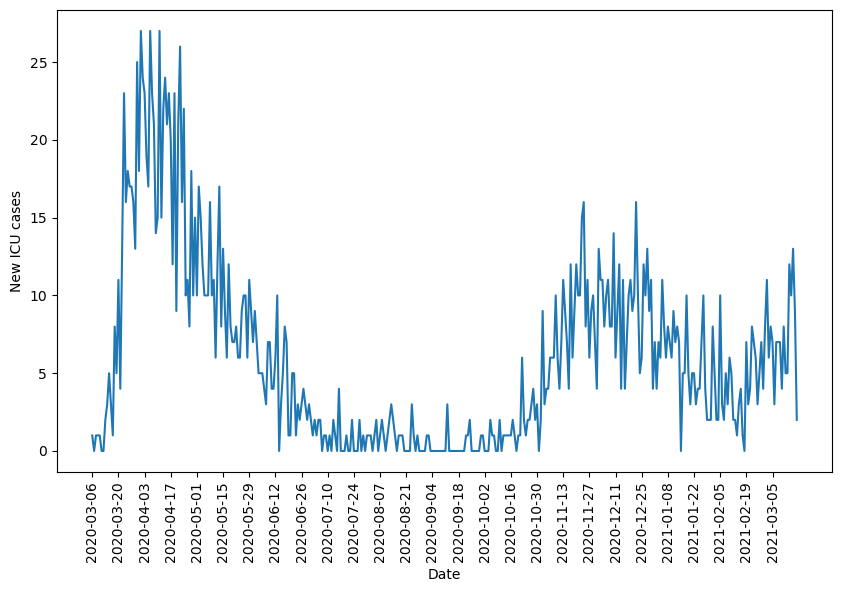

In [2]:
data=pandas.read_csv('SIR_Stockholm.csv',header=0)
y_sthlm = data['ICU'].values
u_sthlm = data['Date'].values
ndata = len(y_sthlm)
plt.plot(u_sthlm,y_sthlm)
plt.xticks(range(0, ndata, 14), u_sthlm[::14], rotation = 90)  # Show only one tick per 2 week for clarity
plt.xlabel('Date')
plt.ylabel('New ICU cases')
plt.show()

**Q0:** What type of values can the observations $y_t$ take? Is a Gaussian likelihood model a good choice if we want to respect the properties of the data?

**A:** *Since,$y_t$ can only take positive values, we can only use a distribution that is supported on positive semi-infinite intervals i.e. $[0,\infty)$. Examples are the Gamma family, Weibull, log normal etc. The Gaussian likelihood model would not be a good choice here.*

## 3.2 Setting up and simulating the SEIR model
In this section we will set up a SEIR model and use this to simulate a synthetic data set. You should keep these simulated trajectories, we will use them in the following sections.

In [3]:
from tssltools_lab3 import Param, SEIR

"""For Stockholm the population is probably roughly 2.5 million."""
population_size = 2500000  

"""" Binomial probabilities (p_se, p_ei, p_ir, and p_ic) and the transmission rate (rho)"""
pse = 0        # This controls the rate of spontaneous s->e transitions. It is set to zero for this lab.
pei = 1 / 5.1  # Based on FHM report
pir = 1 / 5    # Based on FHM report
pic = 1 / 1000 # Quite arbitrary!
rho = 0.3      # Quite arbitrary!

""" The instantaneous contact rate b[t] is modeled as
  b[t] = exp(z[t])
  z[t] = z[t-1] + epsilon[t], epsilon[t] ~ N(0,sigma_epsilon^2)
"""
sigma_epsilon = .1

""" For setting the initial state of the simulation"""
i0 = 1000  # Mean number of infectious individuals at initial time point
e0 = 5000  # Mean number of exposed...
r0 = 0     # Mean number of recovered
s0 = population_size - i0 - e0 - r0  # Mean number of susceptible
init_mean = np.array([s0, e0, i0, 0.], dtype=np.float64)  # The last 0. is the mean of z[0]

"""All the above parameters are stored in params."""
params = Param(pse, pei, pir, pic, rho, sigma_epsilon, init_mean, population_size)

""" Create a model instance"""
model = SEIR(params)

**Q1:** Generate $10$ different trajectories of length $200$ from the model an plot them in one figure. Does the trajectories look reasonable? Could the data have been generated using this model? 

For reproducability, we set the seed of the random number generator to 0 before simulating the trajectories using np.random.seed(0)

Save these $10$ generated trajectories for future use.

*(hint: The SEIR class has a simulate method)*

In [4]:
np.random.seed(0)
help(model.simulate)

Help on method simulate in module tssltools_lab3:

simulate(T, N=1) method of tssltools_lab3.SEIR instance
    Simulates the SEIR model for a given number of time steps. Multiple trajectories
    can be simulated simulataneously.
    
    Parameters
    ----------
    T : int
        Number of time steps to simulate the model for.
    N : int, optional
        Number of independent trajectories to simulate. The default is 1.
    
    Returns
    -------
    alpha : ndarray
        Array of size (d,N,T) with state trajectories. alpha[:,i,:] is the i:th trajectory.
    y : ndarray
        Array of size (1,N,T) with observations.



In [6]:
alpha, y = SEIR.simulate(model, T = 200, N = 10)


In [68]:
np.shape(y)

(1, 10, 200)

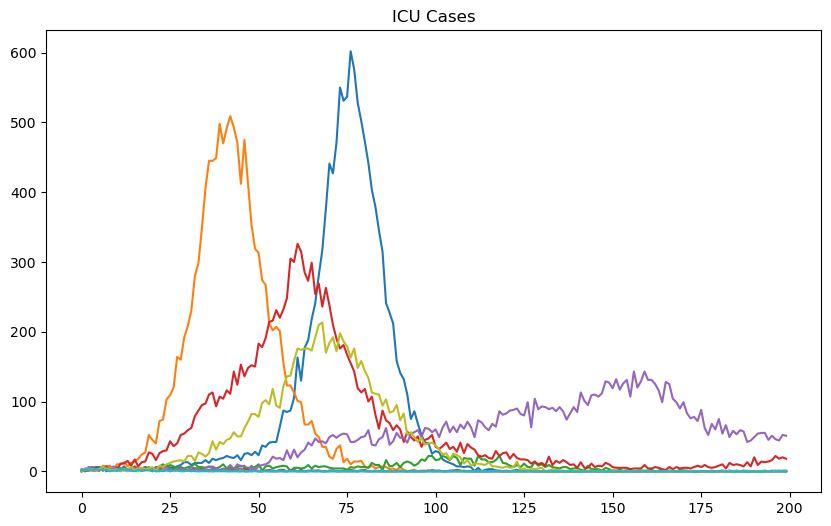

In [49]:
for i in range(10):
    plt.plot(y[0,i,:])
    plt.title('ICU Cases')
    

**A1:** *While the trajectories seem reasonable, but the $y_t$ takes varied values that don't make sense in some of the sample distributions. For eg, in some of the data samples, we are seeing ICU cases go as high as 500-600, but the given data has a peak case load close to 25. So some trajectories are way off. But the shape of the trajectories is within our understanding of the given ICU case data.*

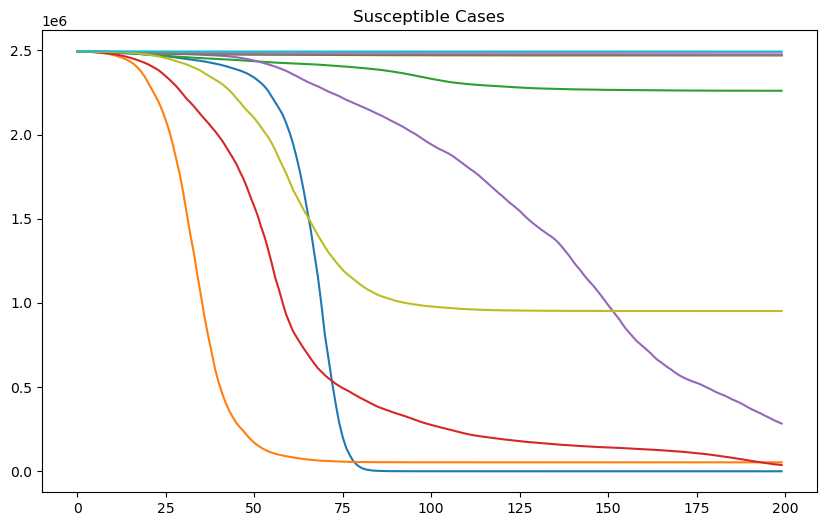

In [12]:
for i in range(10):
    plt.plot(alpha[0,i,:])
    plt.title('Susceptible Cases')

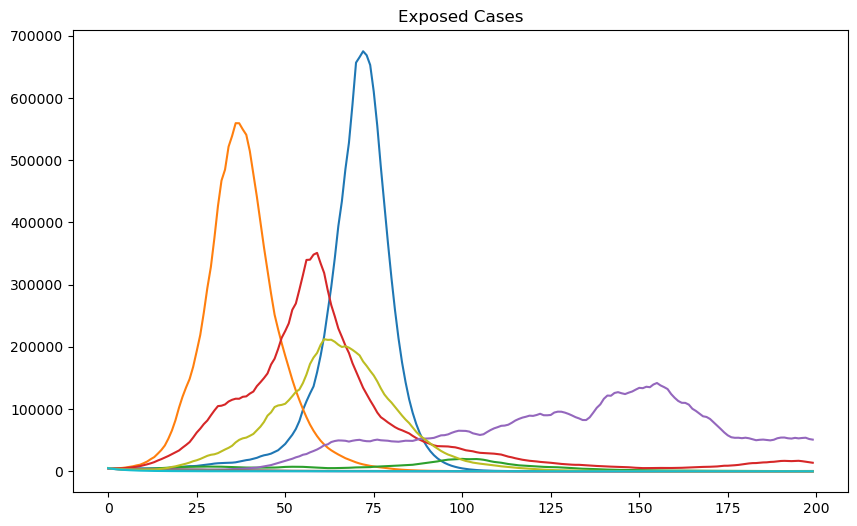

In [13]:
for i in range(10):
    plt.plot(alpha[1,i,:])
    plt.title('Exposed Cases')

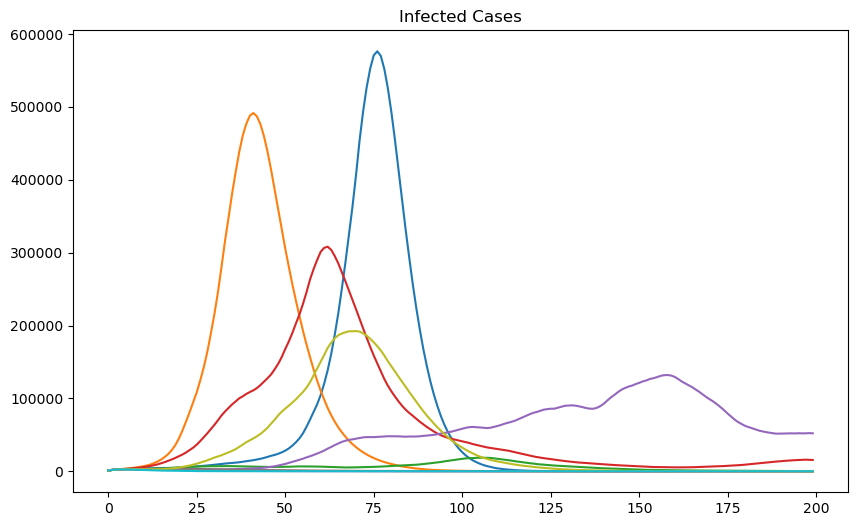

In [17]:
for i in range(10):
    plt.plot(alpha[2,i,:])
    plt.title('Infected Cases')

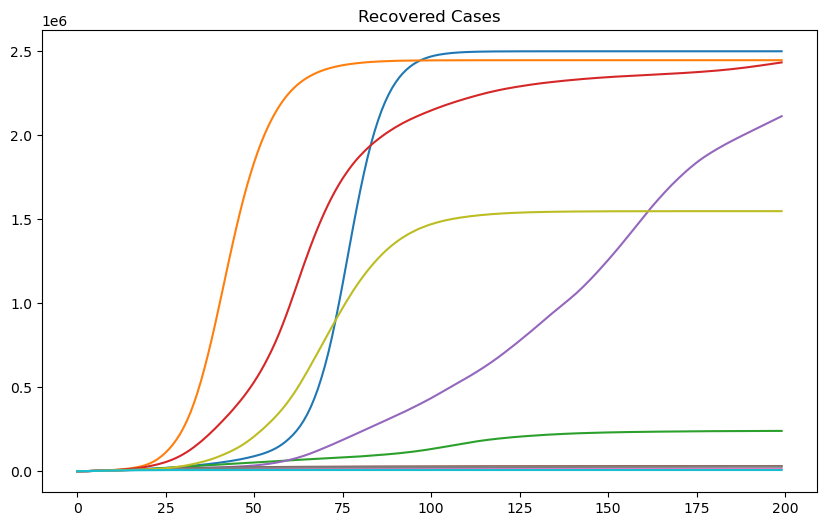

In [30]:
rec_cases = population_size - np.sum(alpha[:3,:,:], axis = 0)

for i in range(10):
    plt.plot(rec_cases[i])
    plt.title('Recovered Cases')

In [31]:
rec_cases.shape

(10, 200)

## 3.3 Sequential Importance Sampling

Next, we pick out one trajectory that we will use for filtering. We use simulated data to start with, since we then know the true underlying SEIR states and can compare the filter results with the ground truth.

**Q2:** Implement the **Sequential Importance Sampling** algorithm by filling in the following functions.

The **exp_norm** function should return the normalized weights and the log average of the unnormalized weights.
For numerical reasons, when calculating the weights we should "normalize" the log-weights first by removing the maximal value.

Let $\bar{\omega}_t = \max(\log \omega_t^i)$ and take the exponential of $\log \tilde{\omega}_t^i = \log \omega_t^i - \bar{\omega}_t$. Normalizing $\tilde{\omega}_t^i$ will yield the normalized weights!

For the log average of the unnormalized weights, care has to be taken to get the correct output,
$\log (1/N \sum_{i=1}^{N} \tilde{\omega}_t^i) = \log( 1/N \sum_{i=1}^{N} \omega_t^i) - \bar{\omega}_t$.
We are going to need this in the future, so best to implement it right away.

*(hint: look at the SEIR model class, it contains all necessary functions for propagation and weighting)*

In [124]:
from tssltools_lab3 import smc_res

def exp_norm(logwgt):
    """
    Exponentiates and normalizes the log-weights.
    
    Parameters
    ----------
    logwgt : ndarray
        Array of size (N,) with log-weights.
    
    Returns
    -------
    wgt : ndarray
        Array of size (N,) with normalized weights, wgt[i] = exp(logwgt[i])/sum(exp(logwgt)),
        but computed in a /numerically robust way/!
    logZ : float
        log of the normalizing constant, logZ = log(sum(exp(logwgt))),
        but computed in a /numerically robust way/!
    """        
    
    N = len(logwgt)
    
    C = max(logwgt)
    
    logwgt_tilde = logwgt - C
    
    omega_tilde = np.exp(logwgt_tilde)
    Omega_tilde = np.sum(omega_tilde)
    
    wgt = omega_tilde / Omega_tilde
    
    #logZ = np.log(Omega_tilde / N) + C
    logZ = np.log(Omega_tilde) + C
    
    return wgt, logZ

def ESS(wgt):
    """
    Computes the effective sample size.
    
    Parameters
    ----------
    wgt : ndarray
        Array of size (N,) with normalized importance weights.
    
    Returns
    -------
    ess : float
        Effective sample size.
    """         
    ess = (np.sum(wgt)**2) / (np.sum(wgt**2))
    
    return ess

def sis_filter(model, y, N):
    d = model.d
    n = len(y)
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:
            particles[:, :, 0] = model.sample_state(alpha0 = None, N = N) # Initialize from p(alpha_1)
            logW[0, :, 0] = model.log_lik(y = y[0], alpha = particles[:, :, 0]) # Compute weights
        else:
            particles[:, :, t] = model.sample_state(alpha0 = particles[:, :, t-1], N = N) # Propagate according to dynamics
            logW[0, :, t] = logW[0, :, t-1] + model.log_lik(y = y[t], alpha = particles[:, :, t]) # Update weights

        # Normalize the importance weights and compute N_eff
        W[0, :, t], logZ = exp_norm(logW[0, :, t])
        N_eff[t] = ESS(W[0,:,t])

        # Compute filter estimates
        alpha_filt[:, 0, t] = np.sum(particles[:, :, t] * W[0, :, t], axis = 1) 
        
    return smc_res(alpha_filt, particles, W, logW=logW, N_eff=N_eff)

**Q3:** Choose one of the simulated trajectories and run the SIS algorithm using $N = 100$ particles. Show plots comparing the filter means from the SIS algorithm with the underlying truth of the Infected, Exposed and Recovered. 

Also show a plot of how the ESS behaves over the run. 

*(hint: In the model we use the S, E, I as states, but S will be much larger than the others. To calculate R, note that S + E + I + R = Population)*

Text(0.5, 1.0, 'Trajectory = 2')

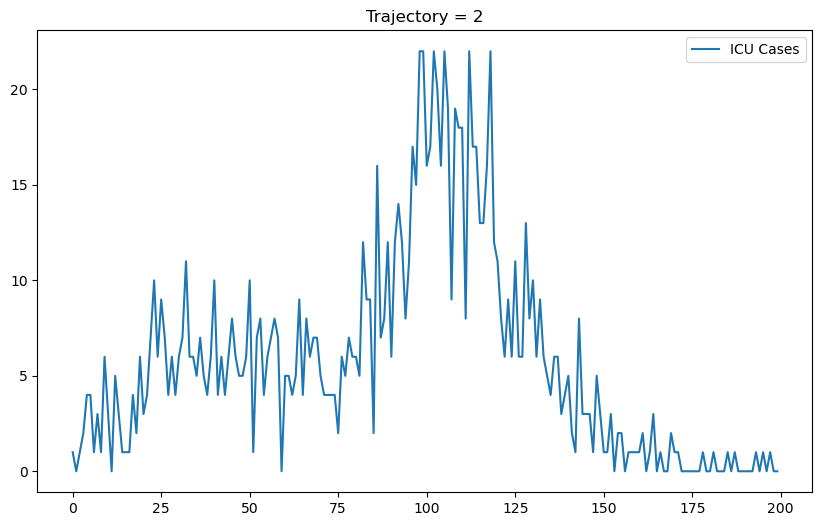

In [67]:
plt.plot(y[0,2,:], label = 'ICU Cases')
#plt.plot(alpha[0,2,:], label = 'Susceptible')
#plt.plot(alpha[1,2,:], label = 'Exposed')
#plt.plot(alpha[1,2,:], label = 'Infected')
#plt.plot(rec_cases[2], label = 'Recovered')
plt.legend()
plt.title('Trajectory = 2')

[Text(0.5, 1.0, 'Recovered')]

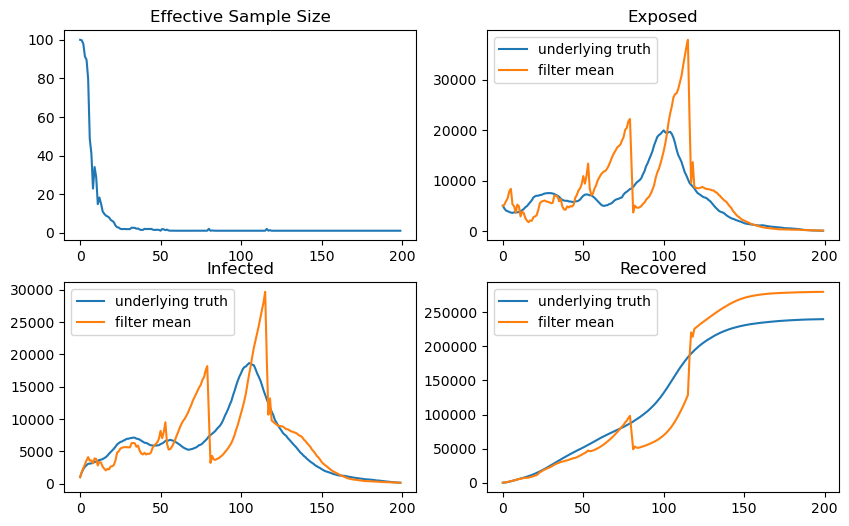

In [196]:
select_trajectory = 2

sis_2 = sis_filter(model = model,
                   y = y[0, select_trajectory, :],
                   N = 100)

rec_cases_truth = population_size - np.sum(alpha[:3, select_trajectory, :], axis = 0)

rec_cases_sis = population_size - np.sum(sis_2.alpha_filt[:3, 0, :], axis = 0)

fig, ax = plt.subplots(2, 2)

#ax[0,0].plot(alpha[0, select_trajectory, :], label = 'underlying truth')
#ax[0,0].plot(sis_2.alpha_filt[0, 0, :], label = 'filter mean')
#ax[0,0].legend()
#ax[0,0].set(title = 'Susceptible')

ax[0,0].plot(sis_2.N_eff)
ax[0,0].set(title = 'Effective Sample Size')

ax[0,1].plot(alpha[1, select_trajectory, :], label = 'underlying truth')
ax[0,1].plot(sis_2.alpha_filt[1, 0, :], label = 'filter mean')
ax[0,1].legend()
ax[0,1].set(title = 'Exposed')

ax[1,0].plot(alpha[2, select_trajectory, :], label = 'underlying truth')
ax[1,0].plot(sis_2.alpha_filt[2, 0, :], label = 'filter mean')
ax[1,0].legend()
ax[1,0].set(title = 'Infected')

ax[1,1].plot(rec_cases_truth, label = 'underlying truth')
ax[1,1].plot(rec_cases_sis, label = 'filter mean')
ax[1,1].legend()
ax[1,1].set(title = 'Recovered')

*Comments: The filter means behave very erratically with increasing time steps and the resulting distribution is not a very good estimation of the underlying truth. The reason for this erratic behavior lies in the weight degeneracy problem (due to repeated multiplication in calculation of weights) that lies in the SIS algorithm. The Effective sample size drops to $\approx1$ after some time steps, i.e. only 1 particle is contributing to each filter estimation.*

## 3.4 Sequential Importance Sampling with Resampling

Pick the same simulated trajectory as for the previous section.

**Q4:** Implement the **Sequential Importance Sampling with Resampling** or **Bootstrap Particle Filter** by completing the code below.

In [153]:
def bpf(model, y, numParticles):
    d = model.d
    n = len(y)
    N = numParticles
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:  # Initialize from prior
            particles[:, :, 0] = model.sample_state(alpha0 = None, N = N) 
        else:  # Resample and propagate according to dynamics
            ind = np.random.choice(N, N, replace=True, p=W[0, :, t-1])
            resampled_particles = particles[:, ind, t-1] 
            particles[:, :, t] = model.sample_state(alpha0 = resampled_particles, N = N) 

        # Compute weights
        logW[0, :, t] = model.log_lik(y = y[t], alpha = particles[:, :, t]) 
        W[0, :, t], logZ_now = exp_norm(logW[0, :, t])
        logZ +=  logZ_now - np.log(N) # Update log-likelihood estimate
        N_eff[t] = ESS(W[0, :, t]) 

        # Compute filter estimates
        alpha_filt[:, 0, t] = np.sum(particles[:, :, t] * W[0, :, t], axis = 1)  
        
    return smc_res(alpha_filt, particles, W, N_eff = N_eff, logZ = logZ)

**Q5:** Use the same simulated trajectory as above and run the BPF algorithm using $N = 100$ particles. Show plots comparing the filter means from the Bootstrap Particle Filter algorithm with the underlying truth of the Infected, Exposed and Recovered. Also show a plot of how the ESS behaves over the run. Compare this with the results from the SIS algorithm.

[Text(0.5, 1.0, 'Recovered')]

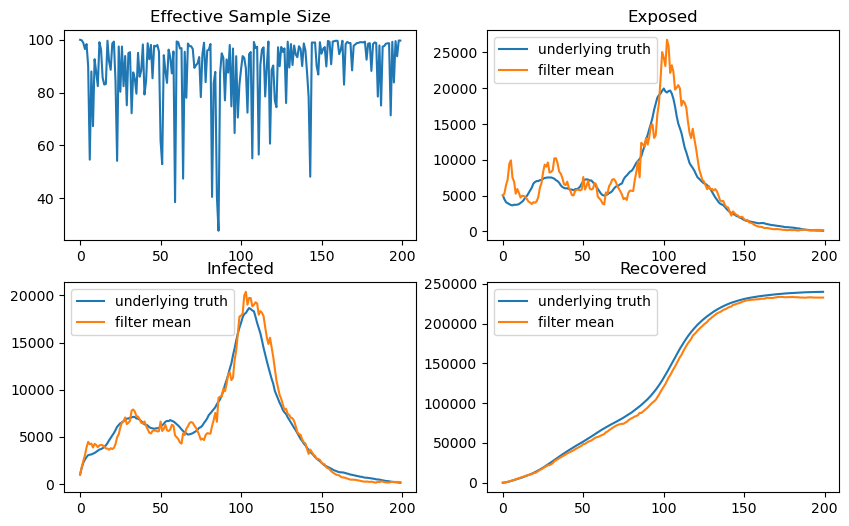

In [198]:
sis_resampling_2 = bpf(model = model,
                       y = y[0, select_trajectory, :],
                       numParticles = 100)

rec_cases_truth = population_size - np.sum(alpha[:3, select_trajectory, :], axis = 0)

rec_cases_sis = population_size - np.sum(sis_resampling_2.alpha_filt[:3, 0, :], axis = 0)

fig, ax = plt.subplots(2, 2)

#ax[0,0].plot(alpha[0, select_trajectory, :], label = 'underlying truth')
#ax[0,0].plot(sis_resampling_2.alpha_filt[0, 0, :], label = 'filter mean')
#ax[0,0].legend()
#ax[0,0].set(title = 'Susceptible')

ax[0,0].plot(sis_resampling_2.N_eff)
ax[0,0].set(title = 'Effective Sample Size')

ax[0,1].plot(alpha[1, select_trajectory, :], label = 'underlying truth')
ax[0,1].plot(sis_resampling_2.alpha_filt[1, 0, :], label = 'filter mean')
ax[0,1].legend()
ax[0,1].set(title = 'Exposed')

ax[1,0].plot(alpha[2, select_trajectory, :], label = 'underlying truth')
ax[1,0].plot(sis_resampling_2.alpha_filt[2, 0, :], label = 'filter mean')
ax[1,0].legend()
ax[1,0].set(title = 'Infected')

ax[1,1].plot(rec_cases_truth, label = 'underlying truth')
ax[1,1].plot(rec_cases_sis, label = 'filter mean')
ax[1,1].legend()
ax[1,1].set(title = 'Recovered')

*Comments: Bootstrapping helps to avoid the earlier problem of weights degenerating. As we can see, due to resampling, the number of particles never drops too significantly. Thus, each estimation has more particles contributing, and hence, we see a better estimate of the filter distributions.*

## 3.5 Estimating the data likelihood and learning a model parameter
In this section we consider the real data and learning the model using this data. For simplicity we will only look at the problem of estimating the $\rho$ parameter and assume that others are fixed.

You are more than welcome to also study the other parameters.

Before we begin to tweak the parameters we run  the particle filter using the current parameter values to get a benchmark on the log-likelihood.

**Q6:** Run the bootstrap particle filter using $N=200$ particles on the real dataset and calculate the log-likelihood. Rerun the algorithm 20 times and show a box-plot of the log-likelihood.

Text(0.5, 1.0, 'Log-Likelihood Boxplot')

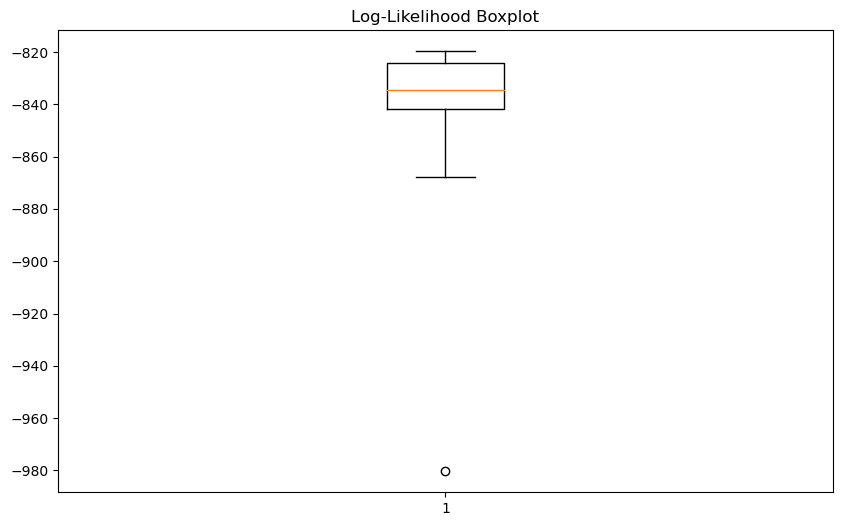

In [208]:
LL_20 = np.zeros(20)

for i in range(20):
    sis_bsp = bpf(model = model,
                  y = y_sthlm,
                  numParticles = 200)
    LL_20[i] = sis_bsp.logZ
    
plt.boxplot(LL_20)
plt.title('Log-Likelihood Boxplot')

In [209]:
LL_20

array([-865.66778833, -822.36851628, -867.86958227, -819.73893257,
       -834.19234254, -840.69915656, -830.44459923, -825.75259769,
       -824.38309815, -835.20200177, -824.98825537, -838.07602767,
       -855.79020681, -824.28855572, -837.64365587, -845.38633779,
       -822.34515984, -840.08715   , -980.32381647, -822.88386422])

*Comment: By observing a boxplot of the log-likelihood values, we can see that there are multiple metrics that we can use as estimates of the log-likelihood (for eg. median, quartiles etc.) because the range is a very close fit and for this run we can only see 1 outlier out of 20 observations. The varying likelihood values can be attributed to the resampling in bootstrapping which results in a different set of particles accounting for the estimate of the log-likelihood values in each run of the algorithm.*

**Q7:** Make a grid of the $\rho$ parameter in the interval $[0.1, 0.9]$. Use the bootstrap particle filter to calculate the log-likelihood for each value. Run the bootstrap particle filter using $N=200$ multiple times (at least 20) per value and use the average as your estimate of the log-likelihood. Plot the log-likelihood function and mark the maximal value.

*(hint: use np.linspace to create a grid of parameter values)*

In [201]:
rho_vec = np.linspace(start = 0.1, stop = 0.9, num = 100)
LL = np.zeros((len(rho_vec), 50))

for i in range(len(rho_vec)):
    model.set_param(rho = rho_vec[i])
    
    for j in range(50):
        sis_bsp_range = bpf(model = model,
                  y = y_sthlm,
                  numParticles = 200)
        LL[i,j] = sis_bsp_range.logZ


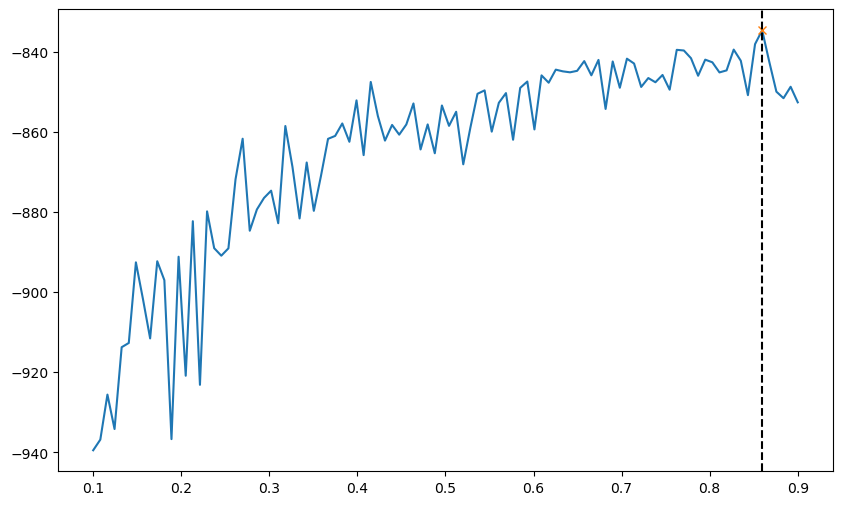

In [202]:
LL_est = np.mean(LL, axis = 1)

plt.plot(rho_vec, LL_est)
plt.plot(rho_vec[LL_est == max(LL_est)], max(LL_est), marker = 'x')
plt.axvline(x = rho_vec[LL_est == max(LL_est)], ls = '--', color = 'black')

*Comment: The log-likelihood value seems to maximize at a value of $\rho \approx 0.86$, hence with respect to this model, we can say that there is approx 86% risk of exposure from each encounter with an infectious person.*

In [215]:
rho_vec[LL_est == max(LL_est)]

array([0.85959596])

**Q8:** Run the bootstrap particle filter on the full dataset with the optimal $\rho$ value. Present a plot of the estimated Infected, Exposed and Recovered states.

[Text(0.5, 1.0, 'Recovered')]

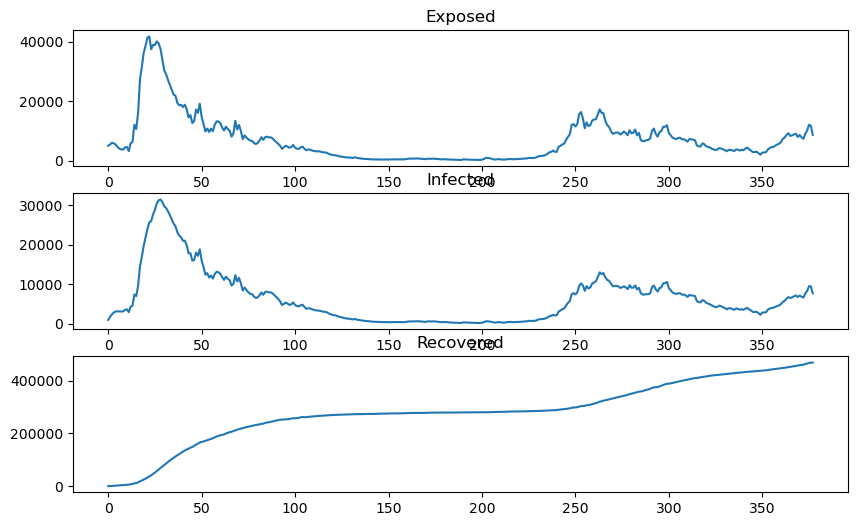

In [218]:
optimal_rho = rho_vec[LL_est == max(LL_est)]

model.set_param(rho = optimal_rho)

sis_bsp_final = bpf(model = model,
                    y = y_sthlm,
                    numParticles = 200)

rec_cases_bsp = population_size - np.sum(sis_bsp_final.alpha_filt[:3, 0, :], axis = 0)

fig, ax = plt.subplots(3, 1)

ax[0].plot(sis_bsp_final.alpha_filt[1, 0, :])
ax[0].set(title = 'Exposed')

ax[1].plot(sis_bsp_final.alpha_filt[2, 0, :])
ax[1].set(title = 'Infected')

ax[2].plot(rec_cases_bsp)
ax[2].set(title = 'Recovered')

*Comment: This seems to reflect the original data of ICU cases and seems to follow the model explanation where we see 2 surges of COVID infection in Stockholm.*